# Kaggle: Shelter Animal Outcomes Model Building and Visualization

In March 2016, [Kaggle released](https://www.kaggle.com/c/shelter-animal-outcomes) an eductional dataset to see how the community might predict outcomes for shelter animals. The dataset was provided by the [Austin Animal Shelter](http://www.austintexas.gov/department/animal-services) in order to better predict whether an animal is at risk for euthanization. This Jupyter workbook was built in April 2016 as a way to walk through the different components of machine learning as a learning resource for others and *hopefully* a useful model for the Austin Animal Shelter.

This Jupyter notebook walks through all the aspects of machine learning including:
* Data Loading with **Pandas**
* Exploratory Data Analysis (EDA) and Feature Engineering
* Visualization with **Bokeh** (a newer python data visualizaiton library)
* Engineering additional features using web-scraping techniques 
* Feature Selection with **Random Forest**
* Predictive modelling with **sckit-learn / XGBoost** (cross-validation, parameter tuning, output format)

This Jupyter notebook, related code and data are also available via [GitHub](https://github.com/dtromero/kaggle-shelter-animals-outcomes).

To begin with, let's load in the different libraries needed by the Jupyter notebook.

In [1]:
import os                                          # access the machine to change working directory
import pandas as pd                                # dataframes for easy data loading/processing/analysis
pd.set_option('display.max_columns', None)         # show all columns when printing dataframes

import numpy as np                                 # access useful functions like np.nan
import re                                          # regular expression library for easy text matching

# bokeh is a data visualization library to build beautiful visualization
from bokeh.charts import Bar, BoxPlot, TimeSeries, output_file,\
                            show, output_notebook, Histogram, hplot
from bokeh.models import HoverTool, ColumnDataSource, WheelZoomTool,\
                            ResetTool, BoxZoomTool, PanTool, PrintfTickFormatter
output_notebook()                                  # prints visuals inline in Jupyter notebook

Loading BokehJS ...

## Data Loading
The following code loads data from the Kaggle contest into pandas dataframes and adds a column designating `train/test` to make later segmentation easy. It then merges the two dataframes into one titled `full`.

In [2]:
# load in the datasets to pandas
sample = pd.read_csv(u'data/sample_submission.csv.gz')
test = pd.read_csv(u'data/test.csv.gz')
train = pd.read_csv(u'data/train.csv.gz')

# adding a column to segment data after merging
test['fileName'] = 'test'
train['fileName'] = 'train'

train.rename(columns={'AnimalID': 'ID'}, inplace=True)

full = pd.concat((train, test))

print 'Train dataset has %d records with %d columns' % (train.shape[0],train.shape[1])
print 'Test dataset has %d records with %d columns' % (test.shape[0],test.shape[1])


Train dataset has 26729 records with 11 columns
Test dataset has 11456 records with 9 columns


## Exploratory Data Analysis (EDA) and Feature Engineering

Before building a model, it helps to have a strong grasp of the data including some of the relationships that exist. Building this understanding helps with feature engineering and selection which are techniques that can greatly increase the predictive value of your model. Feature engineering can be defined as generating new features from the existing ones. To begin with, let's see what columns we have to build our model from..

In [3]:
print full.columns.tolist()

['AgeuponOutcome', 'AnimalType', 'Breed', 'Color', 'DateTime', 'ID', 'Name', 'OutcomeSubtype', 'OutcomeType', 'SexuponOutcome', 'fileName']


Between the two files `train/test` there are twelve columns. Of these there are seven potential columns to engineer features from for the model to learn. By printing a sampling of this data, we can better understand what we have. For example, the `Ageuponoutcome` field has string representations of ages which we will likely want to convert to numerical values. `AnimalType` shows us that this dataset only contains information on cats and dogs. The `Breed` column has many different options including mixes and multiple breed types. One question we may be able to answer using the `DateTime` field is: What time of year is best for adoptions? We can check if animal `Names` have any effect on the outcome of an animal. Maybe the first letter or the length of the name has some predictive value? Using `SexuponOutcome` we can determine if [Bob Barker was right about getting your animals spayed or neutered](https://www.youtube.com/watch?v=ZytpnElPI_E).

Finally lets inspect the `OutcomeTypes` which have five possible outcomes we can predict for a given animal.

In [4]:
print 'Printing a sample of data for each of the feature columns and the training column outputs:'
feature_cols = ['AgeuponOutcome','AnimalType', 'Breed', 'Color', 'DateTime', 'Name', 'SexuponOutcome']
for col in feature_cols:
    num_ex = 3
    spaces = (20-len(col)) * ' '
    exampleList = train[col].drop_duplicates().head(num_ex).tolist()
    if len(exampleList) == num_ex:
        exampleList.append('...')
    print '  %s:%s%s' % (col, spaces, str(exampleList))
    
print '\n  Training Labels:     %s' % str(train['OutcomeType'].drop_duplicates().tolist())

Printing a sample of data for each of the feature columns and the training column outputs:
  AgeuponOutcome:      ['1 year', '2 years', '3 weeks', '...']
  AnimalType:          ['Dog', 'Cat']
  Breed:               ['Shetland Sheepdog Mix', 'Domestic Shorthair Mix', 'Pit Bull Mix', '...']
  Color:               ['Brown/White', 'Cream Tabby', 'Blue/White', '...']
  DateTime:            ['2014-02-12 18:22:00', '2013-10-13 12:44:00', '2015-01-31 12:28:00', '...']
  Name:                ['Hambone', 'Emily', 'Pearce', '...']
  SexuponOutcome:      ['Neutered Male', 'Spayed Female', 'Intact Male', '...']

  Training Labels:     ['Return_to_owner', 'Euthanasia', 'Adoption', 'Transfer', 'Died']


### Extracting Age Values

Starting with the first field, `AgeuponOutcome` has values like `'1 Month'` or `'2 Years'`. Converting these text values to a continuous variable like days will allow for an apples to apples comparison, this code converts the values to days by parsing the unit time element and converting it to a multiple (eg. 7 for week). Then it multiplies that multiple against the unit of time. For example `2 Weeks` converts to 2 * 7 or 14 days.

Finally, we convert that time to a categorical variable. Some quick google searching suggests that dogs reach adulthood between 9 and 12 months and cats around 12 months. So we will use the 12 month value as the demarcation line for adults. If an animal is less than `1 year` old, it is considered a ***Puppy/Kitten***. Otherwise it's considered an ***Adult*** in this field.

In [5]:
full['unitOfTime'] = train.AgeuponOutcome.apply(lambda x: re.sub('s$', '', str(x).split(' ')[-1]))
full['timeVal'] = train.AgeuponOutcome.apply(lambda x: str(x).split(' ')[0])

daysMultiplier = pd.DataFrame.from_dict([{np.nan:0,'day':1,'week':7,'month':30,'year':365}]).T.reset_index()
daysMultiplier.columns = ['unitOfTime', 'daysMultiplier']
full = pd.merge(full, daysMultiplier, on='unitOfTime', how='left', suffixes=['','_y'])
full['ageInDays'] = full['timeVal'].astype(float) * full['daysMultiplier']
full['ageInYears'] = (full['timeVal'].astype(float) * full['daysMultiplier'])/365
full['ageGrp'] = full['ageInDays'].apply(lambda x: 'Adult' if x > 365 else 'Puppy/Kitten')

print 'Here is an example of age values. For our model, we will use the ageInDays, ageInYears and ageGrp values:'
full[['AgeuponOutcome', 'timeVal', 'unitOfTime', 'daysMultiplier',\
      'ageInDays', 'ageInYears', 'ageGrp']].drop_duplicates().head()

Here is an example of age values. For our model, we will use the ageInDays, ageInYears and ageGrp values:


,AgeuponOutcome,timeVal,unitOfTime,daysMultiplier,ageInDays,ageInYears,ageGrp
0,1 year,1,year,365.0,365.0,1.000000,Puppy/Kitten
2,2 years,2,year,365.0,730.0,2.000000,Adult
3,3 weeks,3,week,7.0,21.0,0.057534,Puppy/Kitten
5,1 month,1,month,30.0,30.0,0.082192,Puppy/Kitten
8,5 months,5,month,30.0,150.0,0.410959,Puppy/Kitten


Now to our first [bokeh](bokeh.pydata.org) visualizaiton! Let's compare the distribution of ages of all the animals in the dataset to the ones that were Euthanized. The first plot below shows the distribution of all the animals in the dataset, most are under 5 years of age. The second shows the ages of animals that were Euthanized, one can see that these distributionvary differently. Euthanized animals seem to be much older than the general population, which is to be expected. There are many more relationships to be found in this data, for example, try replacing *Euathanasia* with *Adoption* and you will notice that the distribution seems to mirror most of the population.

Bokeh also allows you **hover your mouse over the visuals**, which I think is one of the coolest features.

In [6]:
# Pull data in to new objects, one for all animals, one for Euthanized
vizData = full[(full.fileName == 'train')].copy()
vizData2 = full[(full.fileName == 'train') & (full.OutcomeType =='Euthanasia')].copy() #try replacing Euthanasia with 

# Create the hover objects to display useful tooltips in the visuals
hover = HoverTool(tooltips=[("Animal", "@AnimalType"),("Years", "$x{int}"),("Count", "@height{int}")])
hover2 = HoverTool(tooltips=[("Animal", "@AnimalType"),("Years", "$x{int}"),("Count", "@height{int}")])

# Create two histograms one for all animals, one for Euthanized
hist = Histogram(vizData, 'ageInYears', color='AnimalType', bins=20, legend='top_right'\
            ,height=400, width=450, tools = [hover, PanTool(), WheelZoomTool(), BoxZoomTool(), ResetTool()]\
            ,title='Dist of Ages for All Dogs/Cats')
hist2 = Histogram(vizData2, 'ageInYears', color='AnimalType', bins=20, legend='top_right'\
            ,height=400, width=450, tools = [hover2, PanTool(), WheelZoomTool(), BoxZoomTool(), ResetTool()]\
            ,title='Dist of Ages for Euthanized Dogs/Cats')

# hplot allows you to plot two visuals next to each other
p = hplot(hist, hist2)
show(p)

### Extracting Gender and Intactness

The `Sexuponoutcome` field has values like `Neutered Male` or `Intact Female`. We can easily split this field and convert to a `Gender` and `Intactness` field. This will allow us to study the relationships each of these have on the outcome variable. 

In [7]:
full['SexuponOutcome'].fillna('Unknown', inplace=True)
full['Gender'] = full['SexuponOutcome'].apply(lambda x: x.split(' ')[-1] )
full['Intactness'] = full['SexuponOutcome'].apply(lambda x: x.split(' ')[0]\
                     .replace('Spayed', 'Spayed/Neutered') ).replace('Neutered', 'Spayed/Neutered')

# Visualizing the results as a stacked bar chart
outcomes = full[(full.fileName == 'train') & (full.Intactness <> 'Unknown')].copy()\
            .groupby(['Intactness', 'OutcomeType'])['ID'].count()
outcomes = outcomes.groupby(level=0).apply(lambda x: 100*x/float(x.sum())).reset_index()
outcomes.columns = ['Intactness', 'OutcomeType', 'num_animals']

hover = HoverTool(tooltips=[("Outcome", "@OutcomeType"),("Intactness", "$x"),("Number", "@height{int}%")])
bar = Bar(outcomes, label='Intactness', values='num_animals', agg='sum',\
        stack='OutcomeType',height=400, width=450, ylabel='Percent of Animals',\
        tools = [hover, PanTool(), WheelZoomTool(), BoxZoomTool(), ResetTool()]) 

outcomes2 = full[(full.fileName == 'train') & (full.Intactness <> 'Unknown')].copy()\
            .groupby(['Gender', 'OutcomeType'])['ID'].count()
outcomes2 = outcomes2.groupby(level=0).apply(lambda x: 100*x/float(x.sum())).reset_index()
outcomes2.columns = ['Gender', 'OutcomeType', 'num_animals']

hover2 = HoverTool(tooltips=[("Outcome", "@OutcomeType"),("Gender", "$x"),("Number", "@height{int}%")])
bar2 = Bar(outcomes2, label='Gender', values='num_animals', agg='sum',\
        stack='OutcomeType', height=400, width=450, ylabel='Percent of Animals',\
        tools = [hover2, PanTool(), WheelZoomTool(), BoxZoomTool(), ResetTool()]) 

p = hplot(bar, bar2)
show(p)

Let's quickly visualize the outcomes of animals that are *intact* versus *spayed/neutered*. Seems like animals that are *spayed/neutered* are adopted at a much higher (56%) rate than *intact* animals (5%). Additionally, *spayed/neutered* animals are euthanized only 3% of the time while *intact* animals are euthanized at a much higher 12%.

Animal gender seems to have no real effect on `OutcomeType`, both *males and females* are adopted at roughly the same rate of ~40%.

### Extracting Color Features

In [8]:
colorSet = set()
for c in full['Color'].unique().tolist():
    colors = c.split('/')
    for color in colors:
        colorSet.add(color)
for color in colorSet:
    col_title = 'has_%s' % color
    full[col_title] = full['Color'].str.contains(color).astype(int)

In [9]:
mixColors = ['/', 'tricolor', 'calico', 'torbie', 'tabby']
def colorMixBinary(colorString):
    if any(x in colorString for x in mixColors):
        return 'mixedColor'
    else:
        return 'oneColor'

full['ColorMix'] = full['Color'].apply(lambda x: colorMixBinary(x.lower()) )

print full.groupby('ColorMix').size() * 100 / len(full)


ColorMix
mixedColor    70.069399
oneColor      29.930601
dtype: float64


### Extracting Breed Mix Status

One potential feature we could use is whether an animal is purebred or not. The thinking being that someone wanting to adopt an animal may prefer one or the other. We can extract this feature from the dataset by identifying records with the string 'Mix' or '/' character and labeling them as *Mixed Breed*. As we can see, there are only ~5% of animals that are *Purebred*. In addition, the ratios of outcomes don't differ significantly between *Purbred* and *Mixed Breed* animals. This feature will not likely be useful in the algorithm.

In [10]:
def breedMixStatus(breed_str):
    mix_str = ['/', 'Mix']    
    if any(m in breed_str for m in mix_str):
        status = 'Mixed Breed'
    else: status = 'Purebred'
    return status

full['BreedMixStatus'] = full['Breed'].apply(lambda x: breedMixStatus(x))

print "Percent of animals:  "
full.groupby('BreedMixStatus').size() * 100 / len(full)

Percent of animals:  


BreedMixStatus
Mixed Breed    94.799005
Purebred        5.200995
dtype: float64

### Extracting Name Features

In [62]:
full['has_Name'] = full['Name'].isnull()

### Exploiting Datetime Data Leakage

In [117]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

full['DateTime'] = pd.to_datetime(full['DateTime'])

full['is_Monday'] = full['DateTime'].dt.dayofweek.isin([0])
full['is_Tuesday'] = full['DateTime'].dt.dayofweek.isin([1])
full['is_Wednesday'] = full['DateTime'].dt.dayofweek.isin([2])
full['is_Thursday'] = full['DateTime'].dt.dayofweek.isin([3])
full['is_Friday'] = full['DateTime'].dt.dayofweek.isin([4])
full['is_Saturday'] = full['DateTime'].dt.dayofweek.isin([5])
full['is_Sunday'] = full['DateTime'].dt.dayofweek.isin([6])

full['is_Weekend'] = full['DateTime'].dt.dayofweek.isin([5,6])

full['hour']  = full['DateTime'].dt.hour
full['is_busn_hours'] = full['DateTime'].dt.hour.isin([9,10,11,12,13,14,15,16,17])

full['morning'] = full['DateTime'].dt.hour.isin([0,1,2,3,4,5,6,7,8,9,10])
full['midday'] = full['DateTime'].dt.hour.isin([11,12,13,14])
full['evening'] = full['DateTime'].dt.hour.isin([15,16,17,18,19,20,21,22,23,24])

full['day'] = full['DateTime'].dt.day
full['month'] = full['DateTime'].dt.month

#http://www.timeanddate.com/calendar/aboutseasons.html
full['is_winter'] = full['DateTime'].dt.month.isin(['12,1,2'])
full['is_spring'] = full['DateTime'].dt.month.isin(['3,4,5'])
full['is_summer'] = full['DateTime'].dt.month.isin(['6,7,8'])
full['is_fall'] = full['DateTime'].dt.month.isin(['9,10,11'])

holidays = calendar().holidays()
full['is_holiday'] = full['DateTime'].isin(holidays)


## Modeling

In [118]:
not_feature_cols = [u'AgeuponOutcome', u'ID', u'OutcomeSubtype', u'OutcomeType', u'unitOfTime', u'daysMultiplier'
                    ,'Breed', 'Color', 'Name', 'fileName', 'DateTime', 'timeVal' ]
feature_cols = [f for f in full.columns.tolist() if f not in not_feature_cols]
#print feature_cols

In [119]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier 
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split

#feature_cols = ['AnimalType', 'Gender', 'Intactness',\
#                'ageInDays', 'ageInYears', 'ageGrp', 'ColorMix', 'BreedMixStatus'
#                ,'has_Blue', u'has_Black', u'has_White']
train_data = full[full.fileName == 'train'].copy()
all_inputs = pd.get_dummies(train_data[feature_cols]).fillna(0)

#all_classes, predLab = pd.factorize(train_data['OutcomeType'])
all_classes = train_data['OutcomeType']

random_forest_classifier = RandomForestClassifier(n_estimators=100, n_jobs=2)

cv_scores = cross_val_score(random_forest_classifier, all_inputs, all_classes, cv=10)

print 'Average score: {}'.format(np.mean(cv_scores))
print cv_scores


Average score: 0.671219805714
[ 0.6728972   0.66317757  0.68175019  0.6697831   0.67277487  0.66142911
  0.65830838  0.68101835  0.67165855  0.67940075]


In [120]:
(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_classes, train_size=0.75)

random_forest_classifier.fit(training_inputs, training_classes)
random_forest_classifier.score(testing_inputs, testing_classes)

0.66482118808918156

In [130]:
import matplotlib
%matplotlib inline  

param = {'objective':'multi:softprob'}
bst = xgb.XGBClassifier(**param)
bst.fit(training_inputs, training_classes)

print bst.score(testing_inputs, testing_classes)
#xgb.plot_importance(bst)
#bst.feature_importances_

0.671105790813


In [122]:
test_data = full[full.fileName == 'test'].copy()
test_features = pd.get_dummies(test_data[feature_cols]).fillna(0)
test_ids = test_data['ID'].tolist()

#predictions = random_forest_classifier.predict(test_features)
predictions = bst.predict_proba(test_features)
print len(predictions)
predictions

11456


array([[ 0.04669422,  0.00552524,  0.07572784,  0.23417528,  0.6378774 ],
       [ 0.72867429,  0.00117661,  0.00952546,  0.20287791,  0.05774566],
       [ 0.30321833,  0.0060452 ,  0.04699066,  0.19251288,  0.45123294],
       ..., 
       [ 0.00623176,  0.01039761,  0.106013  ,  0.00424771,  0.87310994],
       [ 0.48800966,  0.002674  ,  0.04835699,  0.40197349,  0.05898581],
       [ 0.31611839,  0.02300506,  0.054952  ,  0.31813279,  0.28779179]], dtype=float32)

In [22]:
#import matplotlib
#%matplotlib inline  

#labels, predictionLabels = pd.factorize(training_classes)

#dtrain = xgb.DMatrix(training_inputs, label=labels)
#param = {'bst:max_depth':10, 'bst:eta':1, 'silent':1, 'objective':'multi:softprob', 'num_class': len(predictionLabels)}
#bst = xgb.train(param, dtrain)
#xgb.plot_importance(bst)


In [123]:
print len(random_forest_classifier.feature_importances_)
print len(all_inputs.columns)

pd.DataFrame(zip(all_inputs.columns, random_forest_classifier.feature_importances_ ),\
             columns=['Feature','Score']).sort_values('Score', ascending=False)

100
100


,Feature,Score
74,day,0.098738
1,ageInYears,0.084533
75,month,0.082267
0,ageInDays,0.079754
69,hour,0.075819
94,Intactness_Spayed/Neutered,0.053505
60,has_Name,0.037269
93,Intactness_Intact,0.034351
15,has_White,0.021187
10,has_Black,0.019660


In [124]:
test_data = full[full.fileName == 'test'].copy()
test_features = pd.get_dummies(test_data[feature_cols]).fillna(0)
test_ids = test_data['ID'].tolist()

#predictions = random_forest_classifier.predict(test_features)
#predictions = random_forest_classifier.predict_proba(test_features)
#predictions

In [125]:
print len(test_ids)
print len(predictions)

11456
11456


In [126]:
output = pd.DataFrame(predictions, columns=random_forest_classifier.classes_, index=test_ids)
output.index.name = 'ID'
output = output.reset_index()

In [36]:
#output = pd.get_dummies(pd.DataFrame(zip(test_ids, predictions), columns=['ID','OutcomeType']), prefix='', prefix_sep='')
#output = pd.DataFrame(zip(test_ids, predictions), columns=['ID','OutcomeType'])
#output.head()

In [127]:
output.to_csv(r'output/dtr_22June2016.csv', index=False)

### Engineering additional features using web-scraping techniques 

While this dataset has some interesting features, it lacks some basic heuristics on the animals themselves. For example, one important feature may be the size of the cat or dog (e.g. Small/Medium/Large). Another may be whether the dog is hypoallergenic or not. A third may be the temperment of the animal (e.g. playful, protective, aggressive). All of these factors may be weighing in the mind of someone looking to adopt an animal. Linking our dataset to an open dataset like [Wikipedia](https://en.wikipedia.org/) could provide us with many more features to learn from.

There are two main lists on wikipedia that will parse:
* [List of Dogs Wikipedia](https://en.wikipedia.org/wiki/List_of_dog_breeds) | [GitHub Mirror](https://raw.githubusercontent.com/dtromero/kaggle-shelter-animals-outcomes/master/data/wiki/List_of_dog_breeds.html)
* [List of Cats Wikipedia](https://en.wikipedia.org/wiki/List_of_cat_breeds) | [GitHub Mirror](https://raw.githubusercontent.com/dtromero/kaggle-shelter-animals-outcomes/master/data/wiki/List_of_cat_breeds.html)

Looking at the list, Cats and Dogs are identified differently. In the dog list, the main segmentation is the breed the dog is categorized in multiple dog clubs like the *American Kennel Club*. The cat list, however, seems much more based on *coat* and *pattern*.

Most of the breeds match up to the [List of Dogs Wikipedia](https://en.wikipedia.org/wiki/List_of_dog_breeds) table, however there were 70 or so breeds that did not have a direct one-to-one match in the dataset. 

The **`breed_fix_dict.py`** file imported below is a manual map the Austin breed names to the wikipedia breed name pages. It can be downloaded from my [GitHub repo](https://raw.githubusercontent.com/dtromero/kaggle-shelter-animals-outcomes/master/data/breed_fix_dict.py).

In [82]:
from bs4 import BeautifulSoup
import requests

def wikiBreedsTableParser(wikiURL):
    respond = requests.get(wikiURL)
    soup = BeautifulSoup(respond.text, "lxml")

    data = []
    table = soup.find('table', class_='wikitable')
    rows = table.find_all('tr')

    headers = rows[0].find_all('th')
    headerText = [header.text.strip() for header in headers]
    headerText.append('wikiUrl')
   
    for row in rows[1:-1]:  #skip the header/footer rows
        try: wikiUrl = row.find_all('a')[0].get('href')
        except: wikiUrl = ''
        cols = row.find_all('td')
        cols = [ele.text.strip().encode('utf8') for ele in cols]
        cols.append(wikiUrl)
        data.append([ele for ele in cols])

    wikiBreeds = pd.DataFrame(data, columns=headerText)
    wikiBreeds.Breed = wikiBreeds.Breed.apply(lambda x: x.strip().lower())
    del wikiBreeds['Image'] # no data is pulled into this column
    return wikiBreeds


gitHubURL = r'https://raw.githubusercontent.com/dtromero/kaggle-shelter-animals-outcomes/master/'
dogWikiURL = gitHubURL + r'data/wiki/List_of_dog_breeds.html'
catWikiURL = gitHubURL + r'data/wiki/List_of_cat_breeds.html'

wikiDogBreeds = wikiBreedsTableParser(dogWikiURL)
wikiDogBreeds.columns =  ['WikiBreed', 'Origin', 'Federation Cynologique Internationale',
                              'American Kennel Club', 'Australian National Kennel Council',
                              'Canadian Kennel Club', 'The Kennel Club', 'New Zealand Kennel Club',
                              'United Kennel Club', 'wikiUrl']

wikiCatBreeds = wikiBreedsTableParser(catWikiURL)

In [262]:
import codecs

dataDogBreeds = {}
maxLen = 0
for b in full[full.AnimalType=='Dog']['Breed'].unique():
    mixNames = b.split('/')
    if maxLen < len(mixNames):
        maxLen = len(mixNames)
    for n in range(len(mixNames)):
        breed = mixNames[n].replace('Mix','').strip().lower().encode('utf8')
        if breed not in dataDogBreeds.keys():
            dataDogBreeds[breed] = 1
        else:
            dataDogBreeds[breed] = dataDogBreeds[breed]+1

dataDogBreeds = pd.DataFrame(dataDogBreeds.items(), columns=['DataBreed', 'Cnt'])

dogMap = eval(codecs.open('data/breed_fix_dict.py', 'r', encoding='utf8').read())
dfdogMap = pd.DataFrame.from_dict(dogMap)

dataDogBreeds = pd.merge(dataDogBreeds, dfdogMap, how='left', on='DataBreed')
dataDogBreeds['WikiBreed'].fillna(dataDogBreeds.DataBreed, inplace=True)

In [235]:
print 'Count of Austin Data Dog Breeds: %d' % dataDogBreeds['Breed'].count()
print 'Count of Wiki Data Dog Breeds: %d' % wikiDogBreeds['WikiBreed'].count()

Count of Austin Data Dog Breeds: 197
Count of Wiki Data Dog Breeds: 510


In [265]:
wikiBreeds = pd.merge(dataDogBreeds, wikiDogBreeds, how='left', on='WikiBreed')

In [266]:
dogs = full[full.AnimalType=='Dog'].copy()
dogs['Breed0'] = dogs.Breed.apply(lambda x: x.split('/')[0].replace('Mix','').strip().lower().encode('utf8'))
pd.merge(dogs, wikiBreeds, left_on='Breed0', right_on='DataBreed')
#dogs.head()

,AgeuponOutcome,AnimalID,AnimalType,Breed,Color,DateTime,ID,Name,OutcomeSubtype,OutcomeType,SexuponOutcome,fileName,unitOfTime,timeVal,daysMultiplier,ageInDays,ageGrp,Sex,Intactness,ColorMix,Breed0,DataBreed,Cnt,WikiBreed,Origin,Federation Cynologique Internationale,American Kennel Club,Australian National Kennel Council,Canadian Kennel Club,The Kennel Club,New Zealand Kennel Club,United Kennel Club,wikiUrl
0,1 year,A671945,Dog,Shetland Sheepdog Mix,Brown/White,2014-02-12 18:22:00,NaN,Hambone,NaN,Return_to_owner,Neutered Male,train,year,1,365.0,365.0,Puppy/Kitten,Male,Neutered,mixedColor,shetland sheepdog,shetland sheepdog,19,shetland sheepdog,United Kingdom (Scotland),Group 01 Section 01 #088,Herding Group,Group 5 (Working Dogs),Group 7 - Herding Dogs,Pastoral,Working,Herding Dog,/wiki/Shetland_Sheepdog
1,3 years,A694714,Dog,Shetland Sheepdog/Border Collie,Black/White,2015-03-16 17:05:00,NaN,Remy,Foster,Adoption,Neutered Male,train,year,3,365.0,1095.0,Adult,Male,Neutered,mixedColor,shetland sheepdog,shetland sheepdog,19,shetland sheepdog,United Kingdom (Scotland),Group 01 Section 01 #088,Herding Group,Group 5 (Working Dogs),Group 7 - Herding Dogs,Pastoral,Working,Herding Dog,/wiki/Shetland_Sheepdog
2,10 years,A382251,Dog,Shetland Sheepdog Mix,Brown/White,2014-11-08 19:01:00,NaN,Princess,NaN,Return_to_owner,Spayed Female,train,year,10,365.0,3650.0,Adult,Female,Neutered,mixedColor,shetland sheepdog,shetland sheepdog,19,shetland sheepdog,United Kingdom (Scotland),Group 01 Section 01 #088,Herding Group,Group 5 (Working Dogs),Group 7 - Herding Dogs,Pastoral,Working,Herding Dog,/wiki/Shetland_Sheepdog
3,2 years,A706228,Dog,Shetland Sheepdog,Tricolor,2015-06-27 15:16:00,NaN,Rico,Partner,Transfer,Intact Male,train,year,2,365.0,730.0,Adult,Male,Intact,mixedColor,shetland sheepdog,shetland sheepdog,19,shetland sheepdog,United Kingdom (Scotland),Group 01 Section 01 #088,Herding Group,Group 5 (Working Dogs),Group 7 - Herding Dogs,Pastoral,Working,Herding Dog,/wiki/Shetland_Sheepdog
4,5 months,A702929,Dog,Shetland Sheepdog Mix,White/Tan,2015-05-28 17:30:00,NaN,Sparky,NaN,Adoption,Spayed Female,train,month,5,30.0,150.0,Puppy/Kitten,Female,Neutered,mixedColor,shetland sheepdog,shetland sheepdog,19,shetland sheepdog,United Kingdom (Scotland),Group 01 Section 01 #088,Herding Group,Group 5 (Working Dogs),Group 7 - Herding Dogs,Pastoral,Working,Herding Dog,/wiki/Shetland_Sheepdog
5,2 years,A681897,Dog,Shetland Sheepdog Mix,Sable/White,2014-10-12 13:58:00,NaN,Aspen,Partner,Transfer,Intact Male,train,year,2,365.0,730.0,Adult,Male,Intact,mixedColor,shetland sheepdog,shetland sheepdog,19,shetland sheepdog,United Kingdom (Scotland),Group 01 Section 01 #088,Herding Group,Group 5 (Working Dogs),Group 7 - Herding Dogs,Pastoral,Working,Herding Dog,/wiki/Shetland_Sheepdog
6,9 years,A706957,Dog,Shetland Sheepdog Mix,Brown,2015-07-07 10:07:00,NaN,NaN,Suffering,Euthanasia,Intact Female,train,year,9,365.0,3285.0,Adult,Female,Intact,oneColor,shetland sheepdog,shetland sheepdog,19,shetland sheepdog,United Kingdom (Scotland),Group 01 Section 01 #088,Herding Group,Group 5 (Working Dogs),Group 7 - Herding Dogs,Pastoral,Working,Herding Dog,/wiki/Shetland_Sheepdog
7,15 years,A178569,Dog,Shetland Sheepdog Mix,White/Black,2014-03-23 15:57:00,NaN,Boti,NaN,Return_to_owner,Neutered Male,train,year,15,365.0,5475.0,Adult,Male,Neutered,mixedColor,shetland sheepdog,shetland sheepdog,19,shetland sheepdog,United Kingdom (Scotland),Group 01 Section 01 #088,Herding Group,Group 5 (Working Dogs),Group 7 - Herding Dogs,Pastoral,Working,Herding Dog,/wiki/Shetland_Sheepdog
8,13 years,A609918,Dog,Shetland Sheepdog/Pomeranian,Gold,2015-06-29 18:29:00,NaN,Billy,NaN,Return_to_owner,Neutered Male,train,year,13,365.0,4745.0,Adult,Male,Neutered,oneColor,shetland sheepdog,shetland sheepdog,19,shetland sheepdog,United Kingdom (Scotland),Group 01 Section 01 #088,Herding Group,Group 5 (Working Dogs),Group 7 - Herding Dogs,Pastoral,Working,Herding Dog,/wiki/Shetland_Sheepdog
9,3 years,A669375,D

OutcomeType  Adoption  Died  Euthanasia  Return_to_owner  Transfer
AnimalType                                                        
Cat              4272   147         710              500      5505
Dog              6497    50         845             4286      3917


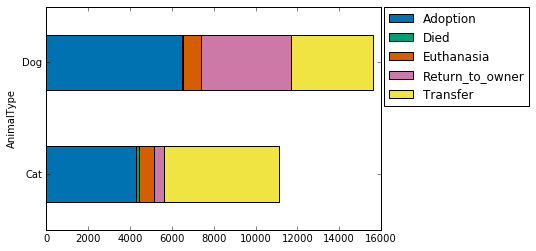

In [7]:
outcomes = train.groupby(['AnimalType', 'OutcomeType'])\
            ['AnimalID'].count().unstack()

print outcomes    
outcomes_plot = outcomes.plot.barh(stacked=True)
outcomes_plot.legend(loc=(1.01,.555), ncol=1)


In [8]:
full.timeVal.unique()

array(['1', '2', '3', '5', '4', '10', '6', '7', '12', '9', '11', '8', '15',
       '0', '14', '16', '13', 'nan', '17', '18', '19', '20'], dtype=object)

In [9]:
full['unitOfTime'].unique()

array(['year', 'week', 'month', 'day', 'nan'], dtype=object)

In [10]:
full['timeVal'].unique()

array(['1', '2', '3', '5', '4', '10', '6', '7', '12', '9', '11', '8', '15',
       '0', '14', '16', '13', 'nan', '17', '18', '19', '20'], dtype=object)

In [179]:
from bokeh.charts import Bar, TimeSeries, output_file, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource
output_notebook()

Loading BokehJS ...

In [180]:
outcomes = train.groupby(['AnimalType', 'OutcomeType'])\
            ['AnimalID'].count().reset_index()
outcomes.columns = ['AnimalType', 'OutcomeType', 'num_animals']
    
hover = HoverTool(
        tooltips=[
            ("Animal", "$x"),  
            ("Outcome", "@OutcomeType"),
            ("Number", "@height{int}"),
        ]
    )
p = Bar(outcomes, label='AnimalType', values='num_animals', agg='sum',\
        stack='OutcomeType', legend='top_left', plot_height=500,\
        tools=[hover]) 
#source = ColumnDataSource(p)
show(p)

In [38]:
outcomes

,ColorMix,OutcomeType,num_animals
0,mix,Adoption,7702
1,mix,Died,135
2,mix,Euthanasia,1091
3,mix,Return_to_owner,3247
4,mix,Transfer,6590
5,single,Adoption,3067
6,single,Died,62
7,single,Euthanasia,464
8,single,Return_to_owner,1539
9,single,Transfer,2832


In [182]:
outcomes = full[full.fileName == 'train'].groupby(['ColorMix', 'OutcomeType'])\
            ['AnimalID'].count().reset_index()
outcomes.columns = ['ColorMix', 'OutcomeType', 'num_animals']
    
hover = HoverTool(
        tooltips=[
            ("Animal", "$x"),  
            ("Outcome", "@OutcomeType"),
            ("Num", "@height{int}"),
        ]
    )
p = Bar(outcomes, label='ColorMix', values='num_animals', agg='sum',\
        stack='OutcomeType', legend='top_left', plot_height=600,\
        tools=[hover]) 
#source = ColumnDataSource(p)
show(p)

In [9]:
# Manual cleansing of the breeds to match wikipedia
dogMap = {'Breed': {0 : 'akita',1 : 'alaskan husky',2 : 'american eskimo',
3 : 'anatol shepherd',4 : 'bedlington terr',5 : 'belgian malinois',
6 : 'belgian sheepdog',7 : 'belgian tervuren',8 : 'bichon frise',
9 : 'black mouth cur',10 : 'bluetick hound',11 : 'boykin span',
12 : 'bruss griffon',13 : 'bull terrier miniature',14 : 'cardigan welsh corgi',
15 : 'catahoula',16 : 'cavalier span',17 : 'chesa bay retr',
18 : 'chihuahua longhair',19 : 'chihuahua shorthair',20 : 'chinese crested',
21 : 'chinese sharpei',22 : 'cirneco',23 : 'cocker spaniel',
24 : 'collie rough',25 : 'collie smooth',26 : 'dachshund longhair',
27 : 'dachshund stan',28 : 'dachshund wirehair',29 : 'dandie dinmont',
30 : 'doberman pinsch',31 : 'dutch shepherd',32 : 'eng toy spaniel',
33 : 'english bulldog',34 : 'english coonhound',35 : 'english pointer',
36 : 'entlebucher',37 : 'flat coat retriever',38 : 'german shepherd',
39 : 'german shorthair pointer',40 : 'glen of imaal',41 : 'jindo',
42 : 'lowchen',43 : 'mastiff',44 : 'mexican hairless',45 : 'miniature poodle',
46 : 'nova scotia duck tolling retriever',47 : 'old english bulldog',
48 : 'patterdale terr',49 : 'pbgv',50 : 'pembroke welsh corgi',
51 : 'picardy sheepdog',52 : 'pit bull',53 : 'podengo pequeno',
54 : 'port water dog',55 : 'presa canario',56 : 'queensland heeler',
57 : 'redbone hound',58 : 'rhod ridgeback',59 : 'schnauzer giant',
60 : 'sealyham terr',61 : 'silky terrier',62 : 'smooth fox terrier',
63 : 'soft coated wheaten terrier',64 : 'st. bernard rough coat',
65 : 'st. bernard smooth coat',66 : 'staffordshire',67 : 'standard poodle',
68 : 'swiss hound',69 : 'toy poodle',70 : 'treeing tennesse brindle',
71 : 'west highland',72 : 'wire hair fox terrier',73 : 'yorkshire'},
 
'WikiBreed': {0 : 'akita inu',1 : 'alaskan klee kai',2 : 'american eskimo dog',
3 : 'anatolian shepherd dog',4 : 'bedlington terrier',
5 : 'belgian shepherd dog (malinois)',6 : 'belgian shepherd dog (groenendael)',
7 : 'belgian shepherd (tervuren)',8 : 'bichon frisé',
9 : 'blackmouth cur',10 : 'bluetick coonhound',11 : 'boykin spaniel',
12 : 'griffon bruxellois',13 : 'bull terrier (miniature)',
14 : 'welsh corgi, cardigan',15 : 'catahoula cur',
16 : 'cavalier king charles spaniel',17 : 'chesapeake bay retriever',
18 : 'chihuahua',19 : 'chihuahua',20 : 'chinese crested dog',21 : 'shar pei',
22 : 'cirneco dell\'etna',23 : 'american cocker spaniel',24 : 'collie, rough',
25 : 'collie, smooth',26 : 'dachshund',27 : 'dachshund',28 : 'dachshund',
29 : 'dandie dinmont terrier',30 : 'doberman pinscher',
31 : 'dutch shepherd dog',32 : 'english cocker spaniel',
33 : 'olde english bulldogge',34 : 'american english coonhound',
35 : 'pointer',36 : 'entlebucher mountain dog',37 : 'flat-coated retriever',
38 : 'german shepherd dog',39 : 'german shorthaired pointer',
40 : 'glen of imaal terrier',41 : 'korean jindo dog',42 : 'löwchen',
43 : 'bullmastiff',44 : 'mexican hairless dog',45 : 'toy poodle',
46 : 'nova scotia duck-tolling retriever',47 : 'olde english bulldogge',
48 : 'patterdale terrier',49 : 'basset griffon vendéen, petit',
50 : 'welsh corgi, pembroke',51 : 'picardy spaniel',
52 : 'american pit bull terrier',53 : 'portuguese podengo',
54 : 'portuguese water dog',55 : 'perro de presa canario',
56 : 'lancashire heeler',57 : 'redbone coonhound',58 : 'rhodesian ridgeback',
59 : 'giant schnauzer',60 : 'sealyham terrier',61 : 'australian silky terrier',
62 : 'fox terrier (smooth)',63 : 'soft-coated wheaten terrier',
64 : 'st. bernard',65 : 'st. bernard',66 : 'staffordshire bull terrier',
67 : 'poodle',68 : 'swedish vallhund',69 : 'toy poodle',
70 : 'tennessee treeing brindle',71 : 'west highland white terrier',
72 : 'fox terrier, wire',73 : 'yorkshire terrier'}}

dfdogMap = pd.DataFrame.from_dict(dogMap)

SyntaxError: EOL while scanning string literal (<string>, line 31)

In [243]:
#simple parsing using pandas, but want to bring in the url for later parsing
#wikiDogBreeds = pd.read_html('https://en.wikipedia.org/wiki/List_of_dog_breeds', header=0)[0]
#wikiDogBreeds['Breed'] = wikiDogBreeds['Breed'].apply(lambda x: x.strip().lower())

from bs4 import BeautifulSoup
import requests

respond = requests.get('https://en.wikipedia.org/wiki/List_of_dog_breeds')
soup = BeautifulSoup(respond.text, "lxml")
                     
data = []
table = soup.find('table', class_='wikitable')
rows = table.find_all('tr')

headers = rows[0].find_all('th')
headerText = [header.text.strip() for header in headers]
headerText.append('wikiUrl')
for row in rows[1:-1]:  #skip the header/footer rows
    wikiUrl = row.find_all('a')[0].get('href')
    cols = row.find_all('td')
    cols = [ele.text.strip().encode('utf8') for ele in cols]
    cols.append(wikiUrl)
    data.append([ele for ele in cols])
wikiDogBreeds = pd.DataFrame(data, columns=headerText)
wikiDogBreeds.Breed = wikiDogBreeds.Breed.apply(lambda x: x.strip().lower())
del wikiDogBreeds['Image'] # no data is pulled into this column
wikiDogBreeds.columns =  ['WikiBreed', 'Origin', 'Federation Cynologique Internationale',
                          'American Kennel Club', 'Australian National Kennel Council',
                          'Canadian Kennel Club', 'The Kennel Club',u'New Zealand Kennel Club',
                          'United Kennel Club', 'wikiUrl']

In [4]:
outcomes = full[(full.fileName == 'train')].copy()
outcomes['Outcome_AnimalType'] =  full.OutcomeType + '_' + full.AnimalType 
hover = HoverTool(tooltips=[("Animal", "$x"),("Value", "$y"),("Height", "@height{int}")])
p = BoxPlot(outcomes, values='ageInYears', label=['Outcome_AnimalType'],
              color='AnimalType', outliers=False, height=400,
              tools = [hover, PanTool(), WheelZoomTool(), BoxZoomTool(), ResetTool()])
show(p)
